In [48]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# %pip install understatapi
from understatapi import UnderstatClient

YEAR = '2023'
LEAGUE = 'Bundesliga'
# get data for every player playing in the Premier League in 2019/20


In [49]:
def process_shot_data(player_shot_data):
    for shot in player_shot_data:
        shot['ScoredEarlier']=0
        shot['ScoredPenEarlier']=0
        shot['ScoredLater']=0
        shot['ScoredPenLater']=0
        shot['PrevAccumXG']=0.0

        # if shot['a_goals']==shot['h_goals']:
        #     shot['State']='tied'
        # elif (shot['a_goals']>shot['h_goals'] and shot['h_a']=='a') or (shot['a_goals']<shot['h_goals'] and shot['h_a']=='h'):
        #     shot['State']='winning'
        # else:
        #     shot['State']='losing'
        # ovo ne radi jer H_GOALS i A_GOALS prikazuju rezultat na kraju, a ne u trenutku suta.
        
        if(shot['result']=='Goal'):
            shot['IsGoal']=True
        else:
            shot['IsGoal']=False


    for i in range(len(player_shot_data)):
        shot = player_shot_data[i]
        original_date = (shot['date'].split()[0])
        if(shot['result']=='Goal'):
            j=i+1
            while  j<len(player_shot_data) and player_shot_data[j]['date'].split()[0] == original_date:
                player_shot_data[j]['ScoredEarlier']=1
                j+=1
            
            
            j=i-1
            while player_shot_data[j]['date'].split()[0] == original_date and j>=0:
                player_shot_data[j]['ScoredLater']=1
                j-=1

    if(len(player_shot_data)==0): return
    prev_date = 'fake date'
    for i in range(len(player_shot_data)):
        shot = player_shot_data[i]
        if shot['date'].split()[0] != prev_date:
            accum_xG = 0.0
            prev_date = shot['date'].split()[0]
        shot['PrevAccumXG']=accum_xG
        accum_xG+=float(shot['xG'])

        
        # print(shot['date'].split()[0])
        # print(shot['minute'])




In [50]:
def prepare_one_dataframe(YEAR, LEAGUE):
    understat = UnderstatClient()
    league_player_ids = set()
    league_player_data = understat.league(league=LEAGUE).get_player_data(season=YEAR)
    league_player_ids.update( [player['id'] for player in league_player_data])

    all_player_shot_data = []
    for player_id in league_player_ids:
        shot_data = understat.player(player=player_id).get_shot_data()
        process_shot_data(shot_data)
        all_player_shot_data+=shot_data





    from heapq import merge


    match_shots = [understat.match(match_info['id']).get_shot_data() for match_info in understat.league(LEAGUE).get_match_data(season = YEAR)]

    all_match_shot_data = []

    for i in range(len(match_shots)):
        team_dic = match_shots[i]
        match=list(merge(team_dic['a'], team_dic['h'], key=lambda shot : int(shot['minute'])))

        home_goals_so_far=0
        away_goals_so_far=0
        for shot in match:
            if shot['h_a']=='h':
                shot['MyScore']=home_goals_so_far
                shot['OppScore']=away_goals_so_far
            else:
                shot['MyScore']=away_goals_so_far
                shot['OppScore']=home_goals_so_far

            if shot['result']=='Goal':
                if shot['h_a']=='h':
                    home_goals_so_far+=1
                else:
                    away_goals_so_far+=1
        match_shots[i]=match
        all_match_shot_data+=match



    matchshotdf = pd.DataFrame(all_match_shot_data).set_index('id')
    matchshotdf.head(10)
    shotdf = pd.DataFrame(all_player_shot_data)
    shotdf['PrevAccumXG'].head(20)
    #shotdf.to_csv(f'../data/shotdf_without_betting_before_processing_{YEAR}_{LEAGUE}.csv')
    shotdf = shotdf[ shotdf['season'] == YEAR ].set_index('id')

    # print(shotdf.head(10),
    # matchshotdf[['MyScore','OppScore']].head(10))
    matchshotdf = matchshotdf[['MyScore','OppScore']]
    #matchshotdf.to_csv(f'../data/scores_{YEAR}_{LEAGUE}.csv')
    shotdf = shotdf.join(matchshotdf, how='inner')

    # shotdf['minute'] = shotdf['minute'].apply(int)
    # shotdf['xG'] = shotdf['xG'].apply(float)

    shotdf = shotdf[['minute', 'xG','h_a','season','h_team','a_team','player','date','ScoredEarlier','ScoredPenEarlier','ScoredLater','ScoredPenLater','IsGoal','MyScore','OppScore','PrevAccumXG']]

    shotdf.to_csv(f'../data/shotdf_without_betting_{YEAR}_{LEAGUE}.csv')

    #test

    shotdf2 = pd.read_csv(f'../data/shotdf_without_betting_{YEAR}_{LEAGUE}.csv')
    print('starting test:')
    print(shotdf.iloc[1])
    print(shotdf2.iloc[1])
    index1 = shotdf.index
    index2 = shotdf2.index
    print(index1[:10])
    print(index2[:10])
    print(len(index1))
    print(len(index2))
    for elem in shotdf.iloc[1]:
        print(type(elem))
    for elem in shotdf2.iloc[1]:
        print(type(elem))
    print('ending test')



In [51]:
shotdf=None
try:
    shotdf = pd.read_csv(f'../data/shotdf_without_betting_{YEAR}_{LEAGUE}.csv')
except Exception:
    prepare_one_dataframe(YEAR, LEAGUE)
    shotdf = pd.read_csv(f'../data/shotdf_without_betting_{YEAR}_{LEAGUE}.csv')

In [52]:
totalxg=shotdf['xG'].sum()
totalgoals=shotdf['IsGoal'].sum()
print(totalgoals / totalxg)
print(len(shotdf[shotdf['ScoredLater']==1]['IsGoal'].index))
print( shotdf[shotdf['ScoredLater']==1]['IsGoal'].sum() / shotdf[ shotdf['ScoredLater'] == 1]['xG'].sum())

0.9266115498923528
814
0.9409883959119649


In [53]:
print(len(shotdf.index))
shotdf = shotdf[shotdf['xG']>0.16]
#if LEAGUE!='EPL': raise Exception('xg penala?')
#DAMN OVO JE ZAPRAVO UHVATILO PROBLEM - u bundesligi je 0.7577, u epl 0.761
shotdf = shotdf[shotdf['xG']<0.75]
print(len(shotdf.index))
shotdf['ScaledIsGoal'] = shotdf['IsGoal'] / shotdf['xG']
shotdf['ScaledIsGoal'].head(30)

8506
1295


17     0.000000
20     1.669470
35     0.000000
36     3.104487
50     3.836969
56     2.222490
63     1.607193
68     0.000000
69     3.005650
75     0.000000
89     1.906719
99     3.334754
101    0.000000
105    0.000000
107    2.318102
108    2.217036
125    0.000000
132    0.000000
142    2.998058
147    0.000000
160    0.000000
161    0.000000
165    4.462016
176    0.000000
178    0.000000
188    2.606151
197    1.666614
213    0.000000
214    0.000000
218    0.000000
Name: ScaledIsGoal, dtype: float64

In [54]:
shotdf.head()

,id,minute,xG,h_a,season,h_team,a_team,player,date,ScoredEarlier,ScoredPenEarlier,ScoredLater,ScoredPenLater,IsGoal,MyScore,OppScore,PrevAccumXG,ScaledIsGoal
17,539348,88,0.391467,a,2023,Werder Bremen,FC Cologne,Damion Downs,2023-09-23 16:30:00,0,0,0,0,False,1,2,0.000000,0.000000
20,579739,91,0.598993,h,2023,FC Cologne,Union Berlin,Damion Downs,2024-05-11 13:30:00,0,0,0,0,True,2,2,0.000000,1.669470
35,543954,56,0.243118,a,2023,Freiburg,Bochum,Christopher Antwi-Adjei,2023-10-21 13:30:00,0,0,0,0,False,1,2,0.037475,0.000000
36,551113,86,0.322114,h,2023,Bochum,Wolfsburg,Christopher Antwi-Adjei,2023-12-02 14:30:00,0,0,0,0,True,2,1,0.000000,3.104487
50,581643,84,0.260622,a,2023,Werder Bremen,Bochum,Christopher Antwi-Adjei,2024-05-18 13:30:00,0,0,0,0,True,0,3,0.047291,3.836969


In [55]:

shotdf['IsHome'] = (shotdf['h_a']=='h').apply(int)
if LEAGUE=='EPL': 
    shotdf['IsPenalty'] = ((shotdf['xG']>0.761) & (shotdf['xG']<0.7615))
elif LEAGUE=='Bundesliga':
    shotdf['IsPenalty'] = ((shotdf['xG']>0.7575) & (shotdf['xG']<0.758))
else: raise Exception('xg penal')
#OMG I OVO JE RADILO GLUP SAM
shotdf['WinProb']=-2.0
shotdf['LoseProb']=-2.0
shotdf['rnd1']=shotdf.index % 3 == 0
shotdf['rnd2']=(shotdf.index % 5 == 0)*3-1
shotdf['ScoreDiff']=shotdf['MyScore']-shotdf['OppScore']
shotdf['ChasingEq'] = (shotdf['ScoreDiff']==-1)
shotdf['ChasingWinner']=(shotdf['ScoreDiff']==0)
shotdf['WastedXG']=shotdf['PrevAccumXG']-1.5*shotdf['ScoredEarlier']
shotdf.loc[shotdf['WastedXG']<0.8, 'WastedXG']=0.0
shotdf['Urgency'] = 90*(shotdf['ChasingEq'] + shotdf['ChasingWinner'])/((120-shotdf['minute']))-1
shotdf['WinningUnderdog'] = 5*(shotdf['LoseProb']-shotdf['WinProb'])+shotdf['ScoreDiff']
shotdf['LosingFavorite']=0.0
shotdf.loc[shotdf['WinningUnderdog']<0, 'LosingFavorite']= -shotdf['WinningUnderdog']
shotdf.loc[shotdf['WinningUnderdog']<0, 'WinningUnderdog']= 0.0

In [56]:
shotdf.head()


,id,minute,xG,h_a,season,h_team,a_team,player,date,ScoredEarlier,...,LoseProb,rnd1,rnd2,ScoreDiff,ChasingEq,ChasingWinner,WastedXG,Urgency,WinningUnderdog,LosingFavorite
17,539348,88,0.391467,a,2023,Werder Bremen,FC Cologne,Damion Downs,2023-09-23 16:30:00,0,...,-2.0,False,-1,-1,True,False,0.0,1.812500,0.0,1.0
20,579739,91,0.598993,h,2023,FC Cologne,Union Berlin,Damion Downs,2024-05-11 13:30:00,0,...,-2.0,False,2,0,False,True,0.0,2.103448,0.0,0.0
35,543954,56,0.243118,a,2023,Freiburg,Bochum,Christopher Antwi-Adjei,2023-10-21 13:30:00,0,...,-2.0,False,2,-1,True,False,0.0,0.406250,0.0,1.0
36,551113,86,0.322114,h,2023,Bochum,Wolfsburg,Christopher Antwi-Adjei,2023-12-02 14:30:00,0,...,-2.0,True,-1,1,False,False,0.0,-1.000000,1.0,0.0
50,581643,84,0.260622,a,2023,Werder Bremen,Bochum,Christopher Antwi-Adjei,2024-05-18 13:30:00,0,...,-2.0,False,2,-3,False,False,0.0,-1.000000,0.0,3.0


In [57]:
import json
betting_nameset = set()
def get_season_betting_data(year, league, no_pages=8, translator=None):
    year = int(year)
    betting_nameset = set()
    jsondata=None
    ctr=0
    for i in range(1,no_pages+1):
        with open(f'../data/betting_{year}_{league}_page_{i}.json') as f:
            jsondata = json.load(f)
        print( jsondata['d']['rows'][0].keys() )

        # print( jsondata['d']['rows'][0]['odds'][2] )
        # print( jsondata['d']['rows'][0]['date-start-timestamp'] )
        if translator is None:
            for row in jsondata['d']['rows']:
                betting_nameset.add(row['home-name'])
            return betting_nameset, None
        else:
            
            for row in jsondata['d']['rows']:
                if row['event-stage-name'][0] in ['a', 'A']:  #after extra time, after penalties etc
                    print('weird game')
                    continue
                ctr+=1
                mask_home = (shotdf['season'] == year) & (shotdf['h_team'] == translator[row['home-name']]) & (shotdf['a_team'] == translator[row['away-name']]) & (shotdf['IsHome']==True)
                mask_away = (shotdf['season'] == year) & (shotdf['h_team'] == translator[row['home-name']]) & (shotdf['a_team'] == translator[row['away-name']]) & (shotdf['IsHome']==False)
                print(mask_home.sum(), mask_away.sum())
                #print(mask.max())
                if mask_home.max()==0 and mask_away.max()==0:
                    print('LOSE', year, row['home-name'], row['away-name'])
                shotdf.loc[mask_home, 'WinProb'] = 1. / row['odds'][0]['avgOdds'] 
                shotdf.loc[mask_home, 'LoseProb'] = 1. / row['odds'][2]['avgOdds']
                shotdf.loc[mask_away, 'LoseProb'] = 1. / row['odds'][0]['avgOdds'] 
                shotdf.loc[mask_away, 'WinProb'] = 1. / row['odds'][2]['avgOdds']
            print(f'{ctr=}')


#ovaj deo sluzi samo za nameset! kasnije se zap koristi get_season_betting_data

names, _ = get_season_betting_data(2023, LEAGUE)
print(names)
# betting_nameset = betting_nameset.union(names)
# names, _ = get_season_betting_data(2020, LEAGUE)
# betting_nameset = betting_nameset.union(names)
# names, _ = get_season_betting_data(2021, LEAGUE)
# betting_nameset = betting_nameset.union(names)
# names, _ = get_season_betting_data(2018, LEAGUE)
# print(names)
# betting_nameset = betting_nameset.union(names)
# names, _ = get_season_betting_data(2022, LEAGUE)
# betting_nameset = betting_nameset.union(names)
# names, _ = get_season_betting_data(2019, LEAGUE)
betting_nameset = betting_nameset.union(names)

# names, _ = get_season_betting_data(2022, LEAGUE)
# betting_nameset = betting_nameset.union(names)


dict_keys(['id', 'is-double', 'superTemplate', 'home', 'away', 'home-name', 'away-name', 'home-country-two-chart-name', 'away-country-two-chart-name', 'home-participant-id', 'away-participant-id', 'status-id', 'event-stage-id', 'event-stage-name', 'event-stage-name-short', 'tournament_id', 'tournament-stage-id', 'tournament-stage-type-id', 'tournament-stage-group-id', 'tournament-stage-name', 'sport-id', 'cols', 'home-participant-images', 'away-participant-images', 'encodeEventId', 'colClassName', 'homeParticipantTypes', 'awayParticipantTypes', 'ftOnly', 'ftOnlyText', 'ftOnlyTextShort', 'url', 'date-start-base', 'date-start-timestamp', 'result', 'homeResult', 'awayResult', 'homeTextInResult', 'awayTextInResult', 'home-winner', 'away-winner', 'postmatchResult', 'info', 'partialresult', 'country-id', 'country-name', 'country-two-chart-name', 'country-type', 'tournament-id', 'tournament-name', 'tournament-url', 'sport-url-name', 'breadcrumbs', 'stream', 'bookmakersCount', 'odds', 'winner_

In [58]:
understat_nameset = set(shotdf['h_team'].tolist())
# shotdf.apply(axis = 1, func = lambda row : understat_nameset.add(row['h_team']))

print(len(shotdf.index))
print(understat_nameset)
shotdf.head()
# beting_iter = iter(betting_nameset)

1295
{'Wolfsburg', 'Bayer Leverkusen', 'RasenBallsport Leipzig', 'Mainz 05', 'Werder Bremen', 'Darmstadt', 'VfB Stuttgart', 'FC Cologne', 'Borussia Dortmund', 'Augsburg', 'Borussia M.Gladbach', 'Bochum', 'Bayern Munich', 'Hoffenheim', 'Freiburg', 'Union Berlin', 'Eintracht Frankfurt', 'FC Heidenheim'}


,id,minute,xG,h_a,season,h_team,a_team,player,date,ScoredEarlier,...,LoseProb,rnd1,rnd2,ScoreDiff,ChasingEq,ChasingWinner,WastedXG,Urgency,WinningUnderdog,LosingFavorite
17,539348,88,0.391467,a,2023,Werder Bremen,FC Cologne,Damion Downs,2023-09-23 16:30:00,0,...,-2.0,False,-1,-1,True,False,0.0,1.812500,0.0,1.0
20,579739,91,0.598993,h,2023,FC Cologne,Union Berlin,Damion Downs,2024-05-11 13:30:00,0,...,-2.0,False,2,0,False,True,0.0,2.103448,0.0,0.0
35,543954,56,0.243118,a,2023,Freiburg,Bochum,Christopher Antwi-Adjei,2023-10-21 13:30:00,0,...,-2.0,False,2,-1,True,False,0.0,0.406250,0.0,1.0
36,551113,86,0.322114,h,2023,Bochum,Wolfsburg,Christopher Antwi-Adjei,2023-12-02 14:30:00,0,...,-2.0,True,-1,1,False,False,0.0,-1.000000,1.0,0.0
50,581643,84,0.260622,a,2023,Werder Bremen,Bochum,Christopher Antwi-Adjei,2024-05-18 13:30:00,0,...,-2.0,False,2,-3,False,False,0.0,-1.000000,0.0,3.0


In [59]:
name_translator = {}
print(betting_nameset)
l_betting_nameset = list(betting_nameset)
for name in l_betting_nameset:
    if name in understat_nameset:
        name_translator[name]=name
        understat_nameset.remove(name)
        betting_nameset.remove(name)
print(betting_nameset)
name_translator['Manchester Utd'] = 'Manchester United'
name_translator['Wolves'] = 'Wolverhampton Wanderers'
name_translator['Newcastle'] = 'Newcastle United'
name_translator['Sheffield Utd'] = 'Sheffield United'
name_translator['Nottingham'] = 'Nottingham Forest'
name_translator['Brentford'] = 'Brentford'
name_translator['Fulham'] = 'Fulham'
name_translator['Leeds'] = 'Leeds'
name_translator['West Brom'] = 'West Bromwich Albion'
name_translator['Luton']='Luton'
name_translator['Huddersfield']='Huddersfield'
name_translator['Cardiff']='Cardiff'
name_translator['B. Monchengladbach'] = 'Borussia M.Gladbach'
name_translator['Dortmund'] = 'Borussia Dortmund'
name_translator['RB Leipzig'] = 'RasenBallsport Leipzig'
name_translator['FC Koln'] =  'FC Cologne'
name_translator['Dusseldorf'] = 'Fortuna Duesseldorf'
name_translator['Mainz'] = 'Mainz 05'
name_translator['Stuttgart']='VfB Stuttgart'
name_translator['Heidenheim']='FC Heidenheim'

{'Bayer Leverkusen', 'Stuttgart', 'Darmstadt', 'Mainz', 'FC Koln', 'Bochum', 'Hoffenheim', 'Freiburg', 'Union Berlin', 'Eintracht Frankfurt', 'Wolfsburg', 'B. Monchengladbach', 'Dusseldorf', 'Werder Bremen', 'Augsburg', 'RB Leipzig', 'Bayern Munich', 'Dortmund', 'Heidenheim'}
{'Stuttgart', 'Mainz', 'FC Koln', 'B. Monchengladbach', 'Dusseldorf', 'RB Leipzig', 'Dortmund', 'Heidenheim'}


In [60]:
print(YEAR)
print(name_translator)
print(type(YEAR))

2023
{'Bayer Leverkusen': 'Bayer Leverkusen', 'Darmstadt': 'Darmstadt', 'Bochum': 'Bochum', 'Hoffenheim': 'Hoffenheim', 'Freiburg': 'Freiburg', 'Union Berlin': 'Union Berlin', 'Eintracht Frankfurt': 'Eintracht Frankfurt', 'Wolfsburg': 'Wolfsburg', 'Werder Bremen': 'Werder Bremen', 'Augsburg': 'Augsburg', 'Bayern Munich': 'Bayern Munich', 'Manchester Utd': 'Manchester United', 'Wolves': 'Wolverhampton Wanderers', 'Newcastle': 'Newcastle United', 'Sheffield Utd': 'Sheffield United', 'Nottingham': 'Nottingham Forest', 'Brentford': 'Brentford', 'Fulham': 'Fulham', 'Leeds': 'Leeds', 'West Brom': 'West Bromwich Albion', 'Luton': 'Luton', 'Huddersfield': 'Huddersfield', 'Cardiff': 'Cardiff', 'B. Monchengladbach': 'Borussia M.Gladbach', 'Dortmund': 'Borussia Dortmund', 'RB Leipzig': 'RasenBallsport Leipzig', 'FC Koln': 'FC Cologne', 'Dusseldorf': 'Fortuna Duesseldorf', 'Mainz': 'Mainz 05', 'Stuttgart': 'VfB Stuttgart', 'Heidenheim': 'FC Heidenheim'}
<class 'str'>


In [61]:
betting_data = None
if LEAGUE == 'EPL':
    betting_data = get_season_betting_data(YEAR, LEAGUE, 8, name_translator)
if LEAGUE == 'Bundesliga':
    betting_data = get_season_betting_data(YEAR, LEAGUE, 7, name_translator)
    

dict_keys(['id', 'is-double', 'superTemplate', 'home', 'away', 'home-name', 'away-name', 'home-country-two-chart-name', 'away-country-two-chart-name', 'home-participant-id', 'away-participant-id', 'status-id', 'event-stage-id', 'event-stage-name', 'event-stage-name-short', 'tournament_id', 'tournament-stage-id', 'tournament-stage-type-id', 'tournament-stage-group-id', 'tournament-stage-name', 'sport-id', 'cols', 'home-participant-images', 'away-participant-images', 'encodeEventId', 'colClassName', 'homeParticipantTypes', 'awayParticipantTypes', 'ftOnly', 'ftOnlyText', 'ftOnlyTextShort', 'url', 'date-start-base', 'date-start-timestamp', 'result', 'homeResult', 'awayResult', 'homeTextInResult', 'awayTextInResult', 'home-winner', 'away-winner', 'postmatchResult', 'info', 'partialresult', 'country-id', 'country-name', 'country-two-chart-name', 'country-type', 'tournament-id', 'tournament-name', 'tournament-url', 'sport-url-name', 'breadcrumbs', 'stream', 'bookmakersCount', 'odds', 'winner_

In [62]:
print(name_translator)

{'Bayer Leverkusen': 'Bayer Leverkusen', 'Darmstadt': 'Darmstadt', 'Bochum': 'Bochum', 'Hoffenheim': 'Hoffenheim', 'Freiburg': 'Freiburg', 'Union Berlin': 'Union Berlin', 'Eintracht Frankfurt': 'Eintracht Frankfurt', 'Wolfsburg': 'Wolfsburg', 'Werder Bremen': 'Werder Bremen', 'Augsburg': 'Augsburg', 'Bayern Munich': 'Bayern Munich', 'Manchester Utd': 'Manchester United', 'Wolves': 'Wolverhampton Wanderers', 'Newcastle': 'Newcastle United', 'Sheffield Utd': 'Sheffield United', 'Nottingham': 'Nottingham Forest', 'Brentford': 'Brentford', 'Fulham': 'Fulham', 'Leeds': 'Leeds', 'West Brom': 'West Bromwich Albion', 'Luton': 'Luton', 'Huddersfield': 'Huddersfield', 'Cardiff': 'Cardiff', 'B. Monchengladbach': 'Borussia M.Gladbach', 'Dortmund': 'Borussia Dortmund', 'RB Leipzig': 'RasenBallsport Leipzig', 'FC Koln': 'FC Cologne', 'Dusseldorf': 'Fortuna Duesseldorf', 'Mainz': 'Mainz 05', 'Stuttgart': 'VfB Stuttgart', 'Heidenheim': 'FC Heidenheim'}


In [63]:
assert (len(shotdf[shotdf['WinProb']==-2].index))==0

In [64]:
shotdf.to_csv(f'../data/shotdf_with_everything_{YEAR}_{LEAGUE}.csv')


In [65]:

# shotdf2 = pd.read_csv(f'../data/shotdf_with_everything_{YEAR}_{LEAGUE}.csv')
# print('starting test:')
# print(shotdf.iloc[1])
# print(shotdf2.iloc[1])
# index1 = shotdf.index
# index2 = shotdf2.index
# print(index1[:10])
# print(index2[:10])
# print(len(index1))
# print(len(index2))
# for elem in shotdf.iloc[1]:
#     print(type(elem))
# for elem in shotdf2.iloc[1]:
#     print(type(elem))
# print('ending test')

In [66]:
shotdf.iloc[6]

id                               577670
minute                               89
xG                             0.622203
h_a                                   a
season                             2023
h_team                        Darmstadt
a_team                    FC Heidenheim
player                   Nikola Dovedan
date                2024-04-28 17:30:00
ScoredEarlier                         0
ScoredPenEarlier                      0
ScoredLater                           0
ScoredPenLater                        0
IsGoal                             True
MyScore                               0
OppScore                              0
PrevAccumXG                         0.0
ScaledIsGoal                   1.607193
IsHome                                0
IsPenalty                         False
WinProb                        0.454545
LoseProb                       0.311526
rnd1                               True
rnd2                                 -1
ScoreDiff                             0


In [67]:
raise Exception('ovaj deo koda je kad hoces da saberes nekoliko godina')
shotdf= pd.read_csv(f'../data/016_076/shotdf_with_everything_2018_{LEAGUE}.csv')
for year in range(2019,2024):
    shotdf = pd.concat([shotdf, pd.read_csv(f'../data/016_076/shotdf_with_everything_{YEAR}_{LEAGUE}.csv')])

print(len(shotdf.index))
shotdf.head()

Exception: 

In [ ]:
#shotdf = shotdf[shotdf['IsPenalty']==True]

model_numbers=[np.float64(0.0007696072606514003), np.float64(-0.06350986223626925), np.float64(-0.06142759525187382), np.float64(-0.10070884596832479), np.float64(0.0), np.float64(0.027035952583909072), np.float64(-0.03850119706820672), np.float64(-0.0), np.float64(0.04310002606906102), np.float64(0.002742111329019352), np.float64(0.8879165898421287)]
    minute  IsHome  ScoredEarlier  Urgency   WinProb  WinningUnderdog  \
17      88       0              0   1.8125  0.348432              0.0   

    LosingFavorite  WastedXG   rnd1  rnd2  
17             1.0       0.0  False    -1  
[0.73186394]


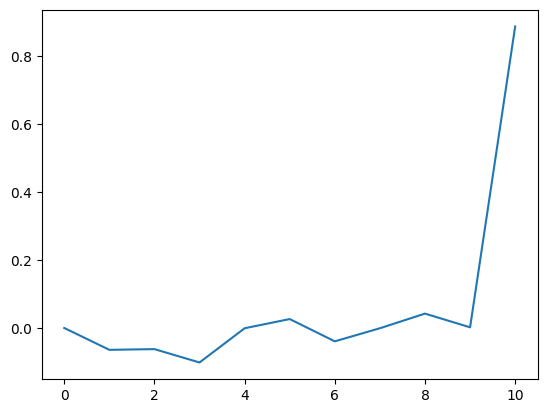

In [68]:
# %pip install scikit-learn
from sklearn.linear_model import LinearRegression, ElasticNet
import numpy as np
#shotdf[shotdf['h_a']=='h']['IsHome'] = 1

all_important_features = ['minute','IsHome','ScoredEarlier','Urgency','WinProb','WinningUnderdog','LosingFavorite','WastedXG','rnd1','rnd2']
# important_features = ['Urgency','WinningUnderdog','LosingFavorite']
important_features = all_important_features
X = shotdf[important_features]
y = shotdf['ScaledIsGoal']



model = ElasticNet(alpha=0.01)
model.fit(X, y)
model_numbers = (list(model.coef_) + [model.intercept_])
plt.plot(model_numbers)
model_df = pd.DataFrame([important_features+['bias'],model_numbers])
model_df.to_csv(f'../results/{YEAR}_{LEAGUE}_016_075_model1.csv')
print(f'{model_numbers=}')
first_shot = (shotdf.iloc[[0]][important_features] )
print(first_shot)
print(model.predict( first_shot))

In [69]:
aware_coefficient = model.predict(shotdf[important_features])
shotdf['AwareXG'] = shotdf['xG']*aware_coefficient
shotdf[['xG','AwareXG']].head(20)

#plt.plot(sorted(aware_coefficient))

,xG,AwareXG
17,0.391467,0.286501
20,0.598993,0.412160
35,0.243118,0.208373
36,0.322114,0.341021
50,0.260622,0.245833
56,0.449946,0.409725
63,0.622203,0.500934
68,0.294244,0.251740
69,0.332707,0.295741
75,0.450806,0.493646


In [70]:
# mask = (shotdf['ScoredEarlier']==1) & (shotdf['IsGoal']==1)
# shotdf[mask]

# mask2 = (shotdf['ScoredEarlier']==1) & (shotdf['PrevAccumXG']==0)
# shotdf[mask2]
print(len(shotdf.index))
# mask3 = (shotdf['h_team']=='Aston Villa') & (shotdf['a_team']=='Crystal Palace')
#shotdf[mask3].sort_values(by='minute').to_csv('../data/wtf_utakimca_prevaccumxg.csv')

1295


# Zastareo kod

In [ ]:
raise Exception

Exception: 

In [ ]:
xg_if_scored_earlier = 0
xg_if_scored_later = 0
total_xg = 0
scored_if_scored_earlier = 0
scored_if_scored_later = 0
total_shots = len(all_player_shot_data)
total_goals = 0
for shot in all_player_shot_data:
    if shot['IsGoal']:
        total_goals+=1
        if shot['ScoredEarlier']==1:
            scored_if_scored_earlier+=1
        if shot['ScoredLater']==1:
            scored_if_scored_later+=1
    if shot['ScoredEarlier']==1:
        xg_if_scored_earlier+=float(shot['xG'])
    if shot['ScoredLater']==1:
        xg_if_scored_later+=float(shot['xG'])
    total_xg += float(shot['xG'])

print(scored_if_scored_earlier, scored_if_scored_later)
print(xg_if_scored_earlier, xg_if_scored_later)
ratio_if_scored_earlier = scored_if_scored_earlier / xg_if_scored_earlier
ratio_if_scored_later = scored_if_scored_later / xg_if_scored_later
ratio_total = total_goals / total_xg
print(f'{ratio_if_scored_earlier=} {ratio_if_scored_later=} {ratio_total=}')

NameError: name 'all_player_shot_data' is not defined

In [ ]:
# print([ lis['id'] for lis in (match_dic[('2015-02-07 15:00:00', 'Leicester', 'Crystal Palace')]) ])
# print([ lis['id'] for lis in (match_dic[('2014-10-04 15:00:00', 'Leicester', 'Burnley')]) ] )

# 'h_team': 'Leicester', 'a_team': 'Burnley', 'h_goals': '2', 'a_goals': '2', 'date': '2014-10-04 15:00:00'


In [ ]:
from functools import reduce
def get_xg_and_goals_for_condition_combination(shot_data, condition_dic):
    keys = list(condition_dic.keys())
    vals = list(condition_dic.values())

    conditional_xg = 0
    conditional_goals = 0

    for shot in shot_data:
        # if len(args)==0 or reduce((lambda x, y: x and y), [shot[arg] for arg in args]):
        if vals == [shot[arg] for arg in keys]:
            conditional_xg += float(shot['xG'])
            conditional_goals += int(shot['IsGoal'])
    return conditional_xg, conditional_goals
print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'ScoredEarlier': True}) )

# 'State' nije dobar. otkomentarisi ovo kad iskoristis match data da 

# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'ScoredEarlier': True ,'State': 'winning'}))
# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'ScoredEarlier': True ,'State': 'tied'}))
# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'ScoredEarlier': True ,'State': 'losing'}))
# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'State': 'winning'}))
# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'State': 'tied'}))
# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'State': 'losing'}))

(1016.7205622913316, 931)


In [ ]:
[1,2]==[True,2]

True

In [ ]:
print(all_player_shot_data[0])

{'id': '52025', 'minute': '3', 'result': 'BlockedShot', 'X': '0.7830000305175782', 'Y': '0.5209999847412109', 'xG': '0.051129300147295', 'player': 'Tom Davies', 'h_a': 'h', 'player_id': '1042', 'situation': 'OpenPlay', 'season': '2015', 'shotType': 'RightFoot', 'match_id': '453', 'h_team': 'Everton', 'a_team': 'Norwich', 'h_goals': '3', 'a_goals': '0', 'date': '2016-05-15 18:00:00', 'player_assisted': 'Kieran Dowell', 'lastAction': 'LayOff', 'ScoredEarlier': 0, 'ScoredPenEarlier': 0, 'ScoredLater': 0, 'ScoredPenLater': 0, 'IsGoal': False}


# Treba da se odradi game state, znaci da li je u trenutku suta taj tim gubio, pobedjivao ili su bili izjednaceni.
Treba u recniku match_data napraviti hronoloski sortiranu listu suteva (koristeci id) koji su ispali golovi.  onda kad se to zavrsi da se vratimo u shot data i da napravimo jos jednu kolonu / key. ovo ovako mora zato sto je shot data prvenstveno sortiran po igracu pa tek onda po vremenu. Treba koristiti match_id i shot_id sto vise, i cinjenicu da je 0-10 puta u istoriji (jako retko lupam brojeve) dato vise golova u istom minutu (sto je dovoljno da ne utice na podatke)

In [ ]:
understat.match('22009').get_shot_data()



{'h': [{'id': '549079',
   'minute': '0',
   'result': 'BlockedShot',
   'X': '0.8590000152587891',
   'Y': '0.2879999923706055',
   'xG': '0.038173574954271317',
   'player': 'Reece James',
   'h_a': 'h',
   'player_id': '8067',
   'situation': 'OpenPlay',
   'season': '2023',
   'shotType': 'RightFoot',
   'match_id': '22009',
   'h_team': 'Chelsea',
   'a_team': 'Manchester City',
   'h_goals': '4',
   'a_goals': '4',
   'date': '2023-11-12 16:30:00',
   'player_assisted': 'Cole Palmer',
   'lastAction': 'BallTouch'},
  {'id': '549080',
   'minute': '11',
   'result': 'BlockedShot',
   'X': '0.8909999847412109',
   'Y': '0.3129999923706055',
   'xG': '0.04885943979024887',
   'player': 'Cole Palmer',
   'h_a': 'h',
   'player_id': '8497',
   'situation': 'OpenPlay',
   'season': '2023',
   'shotType': 'LeftFoot',
   'match_id': '22009',
   'h_team': 'Chelsea',
   'a_team': 'Manchester City',
   'h_goals': '4',
   'a_goals': '4',
   'date': '2023-11-12 16:30:00',
   'player_assisted'

In [ ]:

# match_dic = {}
# def create_match_dic(row):
#     match_dic[(row['date'], row['h_team'], row['a_team'])] = match_dic.get((row['date'], row['h_team'], row['a_team']),[]) + [row]

# shotdf.apply( func = create_match_dic, axis=0)

# print(shotdf.head(10))

# print(list(match_dic.values())[:10])
# for val in match_dic.values():
#     val.sort(key = lambda row : row['minute'])





In [ ]:
(shotdf[shotdf['date']=='2019-08-24 15:00:00'] ).sort_values(by=['h_team','minute']).to_csv('this_date.csv')